# KR-WordRank
- 비지도학습으로 한국어 텍스트에서 키워드를 자동으로 추출해주는 라이브러리
- **주요 가정 : 단어 주변에는 단어가 등장하며, 올바른 단어는 주위의 많은 단어들과 연결되어 있다. 따라서 단어는 주위 단어들에 의하여 단어 점수가 보강(reinforced)된다.**
- [KR-WordRank Reference](https://github.com/lovit/KR-WordRank)
- [Setup]
```
pip install krwordrank
```

### 전체 파일 합치기

In [1]:
import os
os.chdir('../data/')

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_pandas

year = [str(x) for x in range(2018, 2022)]   # 2018 ~ 2021
df = pd.DataFrame(columns = ['year', 'fileName', 'text', 'mecab_preprocessing', 'keywords'])
df

,year,fileName,text,mecab_preprocessing,keywords


In [3]:
for y in tqdm(year):
    fileList = os.listdir('./' + y)
    for file in fileList:
        with open('./' + y + '/' + file, 'r') as f:
            text = f.read().splitlines()
        if text and text[0].strip():
            df_slice = pd.Series([y, file, text[0].strip(), 0, 0], index = df.columns)
            df = df.append(df_slice, ignore_index = True)
# df.to_csv('mecab_all_before_preprocessing.csv', index = False)

100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


In [4]:
df.head()

,year,fileName,text,mecab_preprocessing,keywords
0,2018,한국산업인력공단 지속가능보고서(2017...,지속가능경영 보고서 목차 보고...,0,0
1,2018,LGCNS_Sustainability_Report_2017-2018.pdf.txt,- 보고서 ...,0,0
2,2018,한국국토정보공사 2017 지속가능경영보ᄀ...,지속가능경영보고서 한 국 국 토 정 보 공 사 지 속 가 능 경...,0,0
3,2018,2018 롯데건설 지속가능경영보고서.pdf.txt,롯데건설 지속가능경영보고서 보고서 개요 보고서 특징 롯데건설은 년...,0,0
4,2018,2018_NH투자증권.pdf.txt,투 자 증 권 지 속 가 능 경 영 보 고 서 서울특별시 영등포구 여의...,0,0


In [5]:
len(df)

236

### 정규표현식으로 전처리 + Mecab 형태소 분석

In [9]:
import re
from ekonlpy.tag import Mecab

def preprocessing_regex_mecab_All(text):
    
    afterText = re.sub('[^가-힣]', ' ', text)                # 한글만
    afterText = re.sub('/\r\n|\r|\n/', ' ', afterText)      # 개행문자 제거
    afterText = re.sub(' +', ' ', afterText)                # 연속된 공백 한개로
    
    mecab = Mecab()
    result = mecab.pos(afterText)
    result = [x[0] for x in result]
    
    return result

In [10]:
tqdm.pandas()

df['mecab_preprocessing'] = df['text'].progress_apply(preprocessing_regex_mecab_All)    # tqdm 적용
df.head()

/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 236/236 [04:37<00:00,  1.18s/it]


,year,fileName,text,mecab_preprocessing,keywords
0,2018,한국산업인력공단 지속가능보고서(2017...,지속가능경영 보고서 목차 보고...,"[지속가능경영, 보고서, 목차, 보고서, 개요, 기관, 소개, 지속가능경영, 소개,...",0
1,2018,LGCNS_Sustainability_Report_2017-2018.pdf.txt,- 보고서 ...,"[보고서, 개요, 본, 보고서, 는, 가, 발간, 하, 는, 두, 번, 째, 보고서...",0
2,2018,한국국토정보공사 2017 지속가능경영보ᄀ...,지속가능경영보고서 한 국 국 토 정 보 공 사 지 속 가 능 경...,"[지속가능경영, 보, 고서, 한국, 국, 토, 정보, 공사, 지속가능경영, 보, 고...",0
3,2018,2018 롯데건설 지속가능경영보고서.pdf.txt,롯데건설 지속가능경영보고서 보고서 개요 보고서 특징 롯데건설은 년...,"[롯데, 건설, 지속가능경영, 보, 고서, 보, 고서, 개요, 보고서, 특징, 롯데...",0
4,2018,2018_NH투자증권.pdf.txt,투 자 증 권 지 속 가 능 경 영 보 고 서 서울특별시 영등포구 여의...,"[투자, 증권, 지속가능경영, 보, 고, 서, 서울특별시, 영등포구, 여의대, 로,...",0


In [11]:
df.to_csv('mecab_all_before_extracting_keywords.csv', index = False)

In [24]:
len(df.mecab_preprocessing[0])

103072

### 키워드 추출

summarize_with_keywords(text)와 wordrank_extractor.extract(text, beta, max_iter)는 같은 기능을 함

In [18]:
from krwordrank.word import KRWordRank
from krwordrank.hangle import normalize      # 숫자, 영어 포함 여부
from krwordrank.word import summarize_with_keywords
import numpy as np

def extract_keywords(text):
    error_cnt = 0
    try:
        min_count = 3       # 단어의 최소 출현 빈도수 (그래프 생성 시) [5, 3]
        max_length = 30     # 단어의 최대 길이 [10, 30]
        verbose = False     # [True, False]
        wordrank_extractor = KRWordRank(min_count, max_length, verbose)

        beta = 0.85         # PageRank의 decaying factor beta
        max_iter = 30       # [10, 30]

#         text = normalize(text, english = False, number = False).split(' ')        # wordrank_extractor.extract() 함수를 쓰려면 text가 List 형태여야 함
        keywords, rank, graph = wordrank_extractor.extract(text, beta, max_iter)

#         stopwords = {'대한','의견','단어'}
#         keywords = summarize_with_keywords(text, min_count = 3, max_length = 30, beta = 0.85, max_iter = 30, stopwords = stopwords, verbose = True)
#         keywords = summarize_with_keywords(text)    # with default arguments
        result = sorted(keywords.items(), key = lambda x:x[1], reverse = True)

        # return [result[x][0] for x in range(len(result))]   # 단어만
        return result                                         # 단어 + 점수
    
    except:
        error_cnt += 1
        print(error_cnt)
        
        return np.nan

In [19]:
tqdm.pandas()

df['keywords'] = df['mecab_preprocessing'].progress_apply(extract_keywords)    # tqdm 적용
df.head()

/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 236/236 [00:44<00:00,  5.26it/s]


,year,fileName,text,mecab_preprocessing,keywords
0,2018,한국산업인력공단 지속가능보고서(2017...,지속가능경영 보고서 목차 보고...,"[지속가능경영, 보고서, 목차, 보고서, 개요, 기관, 소개, 지속가능경영, 소개,...","[(습니, 3.0401799665635765), (근로, 2.395539242629..."
1,2018,LGCNS_Sustainability_Report_2017-2018.pdf.txt,- 보고서 ...,"[보고서, 개요, 본, 보고서, 는, 가, 발간, 하, 는, 두, 번, 째, 보고서...","[(서비, 5.429065331331732), (프로, 3.5150395830954..."
2,2018,한국국토정보공사 2017 지속가능경영보ᄀ...,지속가능경영보고서 한 국 국 토 정 보 공 사 지 속 가 능 경...,"[지속가능경영, 보, 고서, 한국, 국, 토, 정보, 공사, 지속가능경영, 보, 고...","[(습니, 4.040246066021655), (정보, 3.2757181262809..."
3,2018,2018 롯데건설 지속가능경영보고서.pdf.txt,롯데건설 지속가능경영보고서 보고서 개요 보고서 특징 롯데건설은 년...,"[롯데, 건설, 지속가능경영, 보, 고서, 보, 고서, 개요, 보고서, 특징, 롯데...","[(롯데, 3.9183914703323666), (습니, 3.234967650112..."
4,2018,2018_NH투자증권.pdf.txt,투 자 증 권 지 속 가 능 경 영 보 고 서 서울특별시 영등포구 여의...,"[투자, 증권, 지속가능경영, 보, 고, 서, 서울특별시, 영등포구, 여의대, 로,...","[(금융, 10.565933996219501), (습니, 3.754872400485..."


In [20]:
df.to_csv('mecab_all_after_keywords.csv', index = False)

### 중복 키워드 확인

In [22]:
keyword_counter = {}

for keywords in df.keywords:
    words, ranks = zip(*keywords)
    for word in words:
        keyword_counter[word] = keyword_counter.get(word, 0) + 1

common_keywords = {word for word, count in keyword_counter.items() if count == len(df)}    # 모든 보고서에 등장하는 키워드
len(common_keywords)

1

In [23]:
common_keywords

{'보고'}

In [24]:
len(keyword_counter)

5727

In [25]:
keyword_counter = sorted(keyword_counter.items(), key = lambda x:x[1], reverse = True)
keyword_counter = list(keyword_counter)
keyword_counter[:10]

[('보고', 236),
 ('습니', 235),
 ('서비', 235),
 ('시스', 235),
 ('사업', 235),
 ('으로', 235),
 ('가능', 235),
 ('입니', 234),
 ('환경', 234),
 ('관리', 233)]

### 키워드 EDA

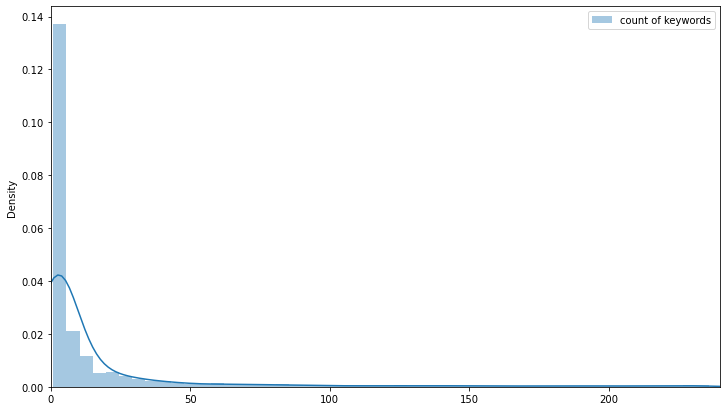

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (12, 7))
sns.distplot(list(zip(*keyword_counter))[1], label = "count of keywords")
plt.xlim(0, 240)
plt.legend()

In [28]:
df_keyword_cnt = pd.DataFrame(list(zip(*keyword_counter))[1], columns = ['count'])
df_keyword_cnt['count'].describe()

count    5727.000000
mean       16.996508
std        38.794163
min         1.000000
25%         1.000000
50%         3.000000
75%        11.000000
max       236.000000
Name: count, dtype: float64